David Fleming 

University of Washington

# Basic Circumbinary Snapshot Analysis

In [68]:
%matplotlib inline
#Imports required to run

import pynbody
SimArray = pynbody.array.SimArray
from matplotlib.pylab import *
import matplotlib.pylab as plt
import pynbody.plot.sph as sph
import numpy as np
from scipy import interpolate

#Tell code where my diskpy distribution is
import os

#Import diskpy and my modules from ICgen submodule
import diskpy
from diskpy.ICgen import *
from diskplot import *

from __future__ import division

#Typical plot parameters that make for pretty plots
plt.rcParams['figure.figsize'] = (10,8)
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=20, usetex=True)

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
mpl.rcParams['font.size'] = 20.0

# Tell code where data is, load using pynbody

In [69]:
#Change directory to where the data is
cwd = '/astro/users/dflemin3/Desktop'
os.chdir(cwd)

In [70]:
#Load Snapshot 
s = pynbody.load('k38_planet.std')

#Center on barycenter
diskCom = binaryUtils.computeCOM(s.stars,s.gas,starFlag=True,gasFlag=True)
s['pos'] -= diskCom

# Look at general binary parameters

In [71]:
#Make sure I have 2 stars in there with correct pos/vel:
print s.stars[0]['pos']
print s.stars[1]['pos']

print s.stars[0]['vel']
print s.stars[1]['vel']

print s.stars[0]['mass']
print s.stars[1]['mass']

#Print current units
print s.stars[0]['pos'].units
print s.stars[0]['vel'].units

[[  2.76623697e-02  -2.16263918e-06  -4.13120405e-07]]
[[ -1.04077545e-01  -2.16263918e-06  -4.13120405e-07]]
[[-0.        0.658243  0.      ]]
[[ 0.        -2.5087254 -0.       ]]
[ 0.949]
[ 0.249]
4.85e-09 kpc
2.98e+01 km s**-1


# Check out disk mass, particle number

In [72]:
print np.sum(s.gas['mass'])
print s.gas['mass'][0], s.gas['mass'].units

# Other bench mark masses
# 0.00191530151739 q_min = 3 = 0.5x M
# 0.00766120606954 2x M
# 0.00383060303477 normal

0.00383060303477
3.83060303477e-08 Msol


In [73]:
print len(s.stars)
print len(s.gas)
print len(s.dm)

3
100000
0


# Binary orbital parameters, center of mass calculations

In [74]:
#Calculate system parameters
x1 = s.stars[0]['pos']
x2 = s.stars[1]['pos']
v1 = s.stars[0]['vel']
v2 = s.stars[1]['vel']
m1 = s.stars[0]['mass']
m2 = s.stars[1]['mass']

ef = AddBinary.calcEcc(x1, x2, v1, v2, m1, m2)
af = AddBinary.calcSemi(x1, x2, v1, v2, m1, m2)
ifin = AddBinary.calcInc(x1, x2, v1, v2)
gf = len(s.g)
mf = s.stars['mass']

print "eccentricity =",ef
print "semimajor axis =",af
print "Inclination =", ifin
print "mass =",mf
print "gas particles =",gf

eccentricity = [ 0.10324991]
semimajor axis = [ 0.14690817]
Inclination = [ 0.]
mass = [  9.49000001e-01   2.48999998e-01   3.44486994e-04]
gas particles = 100000


# Compute average disk quantities, radial profiles of disk orbital elements (specifically eccentricity vs radius)

In [75]:
r, rBinEdges = binaryUtils.calcDiskRadialBins(s,0.25,3.0,50)
orbElems = binaryUtils.orbElemsVsRadius(s,rBinEdges,average=True)

In [76]:
print "Average disk orbital elements: ",binaryUtils.diskAverage(s,r_out=3.0,bins=50,avgFlag=True)

Average disk orbital elements:  [  6.05411935e-03   1.66236127e+00   1.79980051e+00   1.79747153e+02
   1.80199596e+02   1.80050152e+02]


In [77]:
x1, x2 = s.stars[0]['pos'], s.stars[1]['pos']
m1, m2 = s.stars[0]['mass'], s.stars[1]['mass']
v1, v2 = s.stars[0]['vel'], s.stars[1]['vel']
m_disk = np.sum(s.gas['mass'])
x = x1-x2
v = v1-v2
X = [x,v]
test = binary.Binary(X,m1,m2,'cartesian')
print test

(0.10324991296,[ 0.14690817],0.0,0.0,0.0,0.0), mass: ([ 0.949],[ 0.249])


# Examine planet orbital elements

Only run if a planet actually exits.

In [78]:
if len(s.dm) > 0:
    x1 = s.dm['pos']
    x2 = SimArray(np.zeros(len(x1)),x1.units)
    m1, m2 = s.dm['mass'], np.sum(s.stars['mass'])
    v1 = s.dm['vel']
    v2 = SimArray(np.zeros(len(v1)),v1.units)

    r_p = SimArray(np.sqrt(x1[0,0]**2 + x1[0,1]**2),'au')
    mask = s.gas['rxy'] < r_p

    m_disk = np.sum(s.gas['mass'][mask])
    x = x1-x2
    v = v1-v2
    X = [x,v]
    planet = binary.Binary(X,m1,m2+m_disk,'cartesian')
    print planet
    
if len(s.star) > 2:
    x1 = s.stars[2]['pos'].reshape(1,3)
    x2 = SimArray(np.zeros_like(x1),x1.units)

    m1, m2 = s.stars[2]['mass'], (s.stars[0]['mass']+s.stars[1]['mass'])
    v1 = s.stars[2]['vel']
    v2 = SimArray(np.zeros(len(v1)),v1.units)

    r_p = SimArray(np.sqrt(x1[0,0]**2 + x1[0,1]**2),'au')
    mask = s.gas['rxy'] < r_p

    m_disk = np.sum(s.gas['mass'][mask])
    x = x1-x2
    v = v1-v2
    X = [x,v]
    planet = binary.Binary(X,m1,m2+m_disk,'cartesian')
    print planet

(0.00110224900055,[ 0.99832583],0.0,360.0,0.0,179.999998292), mass: ([ 0.00034449],[ 1.19875049])


# Examine disk orbital element radial profiles

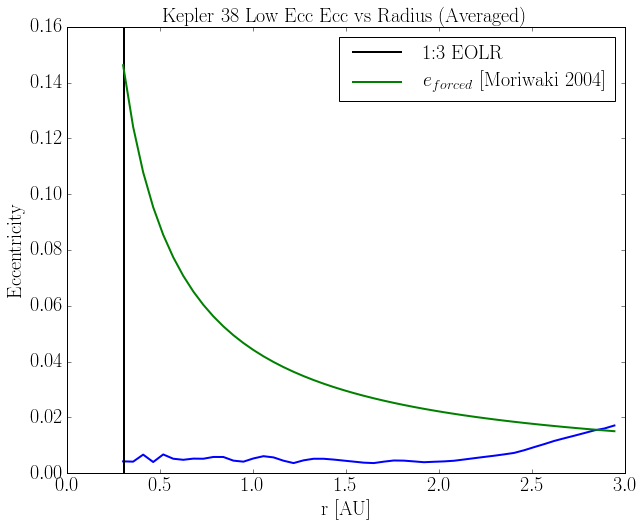

In [79]:
plt.plot(r,orbElems[0,:],linewidth=2)
plt.xlabel('r [AU]')
plt.ylabel('Eccentricity')
plt.title("Kepler 38 Low Ecc Ecc vs Radius (Averaged)")

#Plot lines of interest
loc = 2.08*0.1469
ecc_f = binaryUtils.forcedEccentricity(test,r)*2
plt.axvline(x=loc, ymin=-1, ymax = 1, linewidth=2, color='black',label="1:3 EOLR")
plt.plot(r,ecc_f,color='green',linewidth=2,label="$e_{forced}$ [Moriwaki 2004]")

plt.legend()
#plt.savefig("k38EccVsRadius.pdf")

# Find inner disk edge
Following the prescription of Artymowics+1994, define the gap radius for a circumbinary disk to be at the disk edge position where the surface density is half of the maximum value in the disk.  In that paper, the gap size was studied for various binary eccentricities and mass ratios.  For Kepler 38, the mass ratio is 0.263 ~ 0.3 and the eccentricity is ~0.1.  These values correspond to a gap size of $r = 2.35 \pm 0.15$ times the binary semimajor axis.  For Kepler 38 whose a = 0.1469, one would expect to find after ~ 100 binary orbits a gap radius of ~0.34 au.  This gap formation occurs due to the tidal action of the binary system on the disk (and accretion where applicable).

The initial conditions of Artymowics+1994:

N_gas: ~ $10^4$
Disk Properties: axisymmetric; initialized with Keplerian velocities; $\Sigma \sim 1/r$; introduced binary into initially smooth disk (similar to my initialization).  For a binary with mass parameter $\mu = 0.3$ and eccentricity = 0.1, they found a gap at $r \approx 2.3a$ which is outside the 3:1 orbital period commensurability (Arty+1994 pg. 662).  

In [80]:
#Create profile.  Note: Choose nbins to be the same number of n points ICgen-Binary used to initial generate disk
bins = 500

p = pynbody.analysis.profile.Profile(s,max=' au',min='0.01 au',type='log',nbins=bins)
pg = pynbody.analysis.profile.Profile(s.gas,nbins=bins,max='6 au')

#Get arrays for surface density sigma, radius r
sigma = pg['density']
radius = pg['rbins']

#Select subset of radial points within radius at which sigma = sigmaMax/2 (inner edge of disk)
max_index = np.argmax(sigma)
mask = (radius < radius[max_index])
sigma = sigma[mask]
radius = radius[mask]

#Find location of surface density maximum and look at radius r < r_max to find radius where surface density = max/2.0
halfMax = pg['density'].max()/2.0
#print "Half Max Surface Density = {0} {1}".format(halfMax,pg['density'].units)
    
crit_r = binaryUtils.find_crit_radius(radius,sigma,halfMax,bins)
    
print "Inner gap edge radius = {0}".format(crit_r)

Inner gap edge radius = 0.241592984605


# Plot disk radial profiles

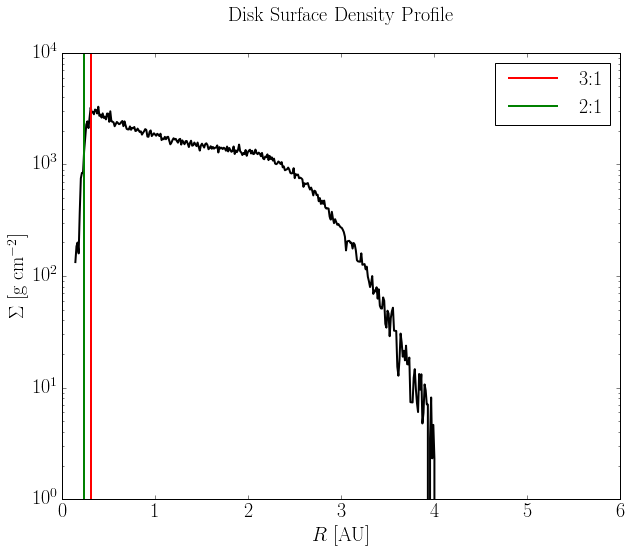

In [81]:
#Try plotting stuff
#Plot the gas surface density as a function of radius for test disk

#Now do the plotting with data derived from gas profile, pg
#In this case, tangential velocity vs. radius
plt.plot(pg['rbins'], pg['density'].in_units("g cm**-2"),'k',linewidth=2)

plt.xlabel("$R$ [AU]")
plt.ylabel(r'$\Sigma$ [g cm$^{-2}$]')
plt.yscale('log')
plt.title('Disk Surface Density Profile',y=1.06)
#plt.xscale('log') #confirm radius powerlaw relation
plt.xlim([0,6])

#Plot lines of interest
#loc = 0.4644 #Radius of Kepler-38b
loc = 2.08*test.a
loc2 = 1.6*test.a
#print float(rCrit)
plt.axvline(x=loc, ymin=-1, ymax = 1, linewidth=2, color='red',label="3:1")
plt.axvline(x=loc2, ymin=-1, ymax = 1, linewidth=2, color='green',label="2:1")

plt.legend(loc='upper right')

#Print units to confirm
#print repr(pg['rbins'].in_units('au'))
#print repr(pg['density'].in_units('g cm**-2'))

#plt.savefig("sigmaVsR.png")

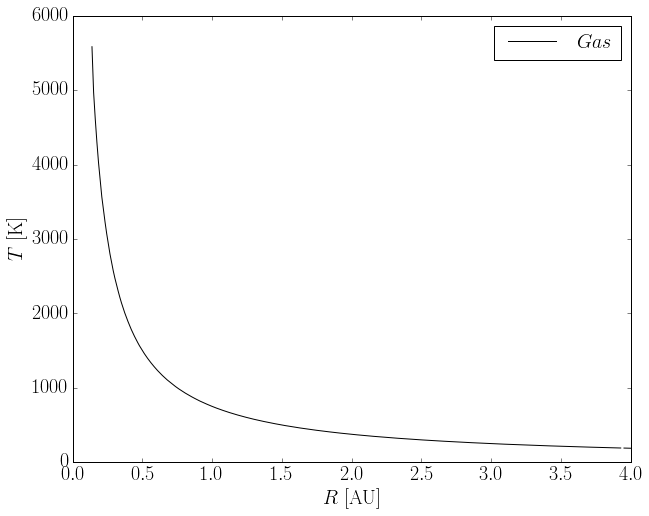

In [82]:
#Try plotting temperature profile of gas in plane of disk
#T vs. radius
plt.plot(pg['rbins'], pg['temp'],'k', label = '$Gas$')
plt.legend()
#plt.semilogy()
#plt.semilogx()
plt.xlabel("$R$ [AU]")
plt.ylabel("$T$ [K]")
plt.show()

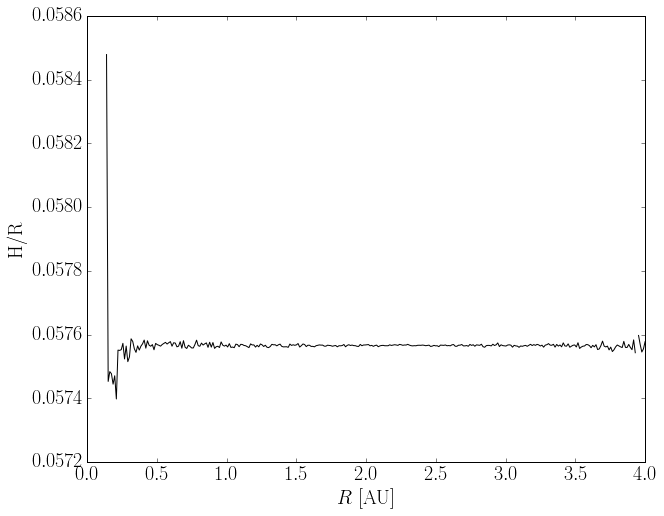

In [83]:
H, H_r = binaryUtils.disk_scale_height(s,bins=len(pg['rbins']),gamma=1)
h = H/H_r

#Try plotting temperature profile of gas in plane of disk
#T vs. radius
plt.plot(pg['rbins'],h,'k', label = '$Gas$')
plt.xlabel("$R$ [AU]")
plt.ylabel("H/R")
plt.show()

# Plot 2D Heatmaps (Histograms) of Density, temperature, and pressure

In [84]:
pynbody.plot.gas.rho_T(s, rho_units='g cm**-3')
plt.title('2D Histogram of Density vs Temperature',y=1.02)

ValueError: zero-size array to reduction operation minimum which has no identity

In [ ]:
pynbody.plot.generic.hist2d(s.gas['temp'],s.gas['p'].in_units('Pa'),xlogrange=True,ylogrange=True,
                           x_range=(2,3.8),y_range=(-5,3));
plt.title('2D Histogram of Temperature vs. Pressure',y=1.02)
plt.xlim(2,3.8)
plt.ylim(-5,3)

# Plot tisk density, temperature, velocity maps.  Lets me see if the disk is forming spiral arms, any weird temperature stuff, is rotating counterclockwise as it should, etc

In [ ]:
#Create nice color plot of temp as function of radius


#pynbody.analysis.angmom.faceon(s1.g)#create an image of gas density integrated
#down the line of site (z axis) of width 50 Au
sph.image(s.gas,qty="rho",units="g cm^-2",width=2,cmap='viridis',
    vmin=1.0e1,vmax=1.0e6)

#Plot circle representing theoretical location of gap...should occur ~ 100 orbits
list_radians = [0]
 
# from degrees to radians, the 0 is already included so
# we don't make the universe collapse by dividing by zero.
for i in range(0,360):
    float_div = 180.0/(i+1)
    list_radians.append(pi/float_div)
     
# list of coordinates for each point
list_x2_axis = []
list_y2_axis = []

ai = 0.1469
r = 2.3*ai #Inner gap edge predicted by Artimowicz+1994 for binary similar to Kepler 38
#r = 0.25
# calculate coordinates
# and append to above list
for a in list_radians:
    list_x2_axis.append(r*cos(a))
    list_y2_axis.append(r*sin(a))
    
#plot the coordinates
#plt.plot(list_x2_axis,list_y2_axis,c='r')
#plt.xlim([-0.5,0.5])
#plt.ylim([-0.5,0.5])

#plt.savefig("pm_iso_32000.pdf")

In [ ]:
#Plot velocity vectors
f, axs = plt.subplots(1,1,figsize=(8,8))

#create a simple slice showing the gas temperature, with velocity vectors overlaid
sph.velocity_image(s.g, vector_color="cyan", qty="temp",width=5,cmap="viridis",
                   denoise=True,approximate_fast=True, show_cbar = True)

#plt.savefig("vectors.pdf")

# Plot heatmaps of disk eccentricity vs radius, argument of periastron vs semimajor axis.  The latter is quite useful for identifying spiral arm structure in the disk.

In [ ]:
x1_gas = s.gas['pos']
x_zero = pynbody.array.SimArray(np.zeros((len(x1_gas),3)),'au')
v1_gas = s.gas['vel']
v_zero = pynbody.array.SimArray(np.zeros((len(x1_gas),3)),'km s**-1')
m1 = np.sum(s.s['mass'])
m2 = s.gas['mass']
gas_m = s.gas['mass'].in_units('g')

cm = binaryUtils.computeCOM(s.stars,s.gas,cutoff=3.0).in_units('au')

#Compute semimajor axis, longitude of perihelion (relative to that of bin) for ALL gas particles
gas_a = AddBinary.calcSemi(x1_gas,cm,v1_gas,v_zero,m1,m2)
gas_e = AddBinary.calcEcc(x1_gas,cm,v1_gas,v_zero,m1,m2)
gas_i = AddBinary.calcInc(x1_gas,cm,v1_gas,v_zero)
gas_w = AddBinary.calcArgPeri(x1_gas,cm,v1_gas,v_zero,m1,m2) + AddBinary.calcLongOfAscNode(x1_gas,x_zero,v1_gas,v_zero)
gas_w = gas_w - (test.Omega + test.w)

gas_theta = SimArray(np.arctan2(s.gas['y'],s.gas['x']),'1')

v_theta = ((s.gas['x'] * s.gas['vy'] - s.gas['y'] * s.gas['vx']) / s.gas['rxy']).in_units('km s**-1')
v_r  = ((s.gas['pos'][:, 0:2] * s.gas['vel'][:, 0:2]).sum(axis=1) / s.gas['rxy']).in_units('km s**-1')

while np.sum(gas_w > 360) > 0:
    gas_w[gas_w > 360] = gas_w[gas_w > 360] - 360.0

while np.sum(gas_w < 0) > 0:    
    gas_w[gas_w < 0] = gas_w[gas_w < 0] + 360.0

inner = 0
outer = 8

x_min = 0
x_max = 360
y_min = inner
y_max = outer
extent = [[x_min,x_max],[y_min,y_max]]

#Filter out gas particles that aren't bound
mask = np.logical_and(gas_e < 1,gas_e > 0)
gas_a = gas_a[mask]
gas_w = gas_w[mask]
gas_e = gas_e[mask]
gas_m = gas_m[mask]
gas_theta = gas_theta[mask]
gas_i = gas_i[mask]
v_theta = v_theta[mask]
v_r = v_r[mask]

#Now Filter gas particles to within a certain distance
mask = np.logical_and(gas_a < outer,gas_a > inner)
gas_a = gas_a[mask]
gas_w = gas_w[mask]
gas_e = gas_e[mask]
gas_m = gas_m[mask]
gas_theta = gas_theta[mask]
gas_i = SimArray(gas_i[mask],'1.0')
v_theta = v_theta[mask]
v_r = v_r[mask]

In [ ]:
x_min = 0
x_max = 360
y_min = 0
y_max = 3
extent = [[x_min,x_max],[y_min,y_max]]

ax, im, cbar = diskplot.plot_heatmap(gas_w,gas_a,labels=['$\Omega + \omega$','Radius [Au]','Overdensity'],
                                    cm='cubehelix',norm='log',avg='y',vmax=1.0e2,vmin=1.0e-2,hist_range=extent)

# Ensure plots are same dimensions
ax.set_xlim(x_min,x_max)
ax.set_ylim(y_min,y_max)

In [ ]:
pynbody.plot.sph.sideon_image(s.gas, width='8 au', linthresh=0.01, cmap='viridis')